In [1]:
import aiohttp
import aiomoex
import random

from os.path import exists
from datetime import datetime
from typing import Callable

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.logger import configure
from finrl.agents.stablebaselines3.models import DRLAgent

import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding

import os
import csv

%matplotlib inline

In [ ]:
# mlflow.set_tracking_uri("http://localhost:5000")

In [2]:
START_DATE = '2022-05-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

In [3]:
async def fetch_moex_data(start_date=START_DATE, end_date=END_DATE, timeframe='H', ticker='SBER'):

    # Маппинг интервалов
    interval_map = {'D': 24, 'W': 7, 'H': 60, 'M': 31, 'm': 1}
    interval = interval_map.get(timeframe, 60)
    print(f"📊 Загружаем данные для {ticker} с {start_date} по {end_date} (таймфрейм: {timeframe})")

    async with aiohttp.ClientSession() as session:
        # Запрашиваем свечные данные
        data = await aiomoex.get_market_candles(
            session,
            security=ticker,
            interval=interval,
            start=start_date,
            end=end_date
        )

    # Проверяем, есть ли данные
    if not data:
        raise ValueError(f"❌ Не удалось получить данные для {ticker}")

    # Создаем DataFrame
    df = pd.DataFrame(data)

    df = df.rename(columns={'begin': 'date'})

    # Преобразуем дату в datetime и ставим индекс
    df['date'] = pd.to_datetime(df['date'])
    # df.set_index('date', inplace=True)

    # Оставляем только нужные столбцы
    df = df[['date', 'open', 'high', 'low', 'close', 'volume']]

    print(f"✅ Загружено {len(df)} свечей для {ticker}")

    return df.sort_values('date')

# df = await fetch_moex_data(ticker="SBER", timeframe='H')
# df.to_csv('data.csv', index=False)
df = pd.read_csv('data.csv')
display(df.head())
print(df.info())

,date,open,high,low,close,volume
0,2022-05-04 09:00:00,129.10,129.10,129.10,129.10,111560
1,2022-05-04 10:00:00,129.10,131.50,125.77,127.00,17793280
2,2022-05-04 11:00:00,127.05,127.50,123.60,123.95,13508120
3,2022-05-04 12:00:00,123.89,126.23,123.60,125.44,6536410
4,2022-05-04 13:00:00,125.44,126.21,124.61,125.35,3540730


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10714 entries, 0 to 10713
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    10714 non-null  object 
 1   open    10714 non-null  float64
 2   high    10714 non-null  float64
 3   low     10714 non-null  float64
 4   close   10714 non-null  float64
 5   volume  10714 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 502.3+ KB
None


In [4]:
### INDICATORS PARAMS ###

rsi_lenght = 9
ema_lenght = 21

In [5]:
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:

    delta = over.diff()
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    rsi.name = 'rsi'

    valid_rsi = rsi[rsi_lenght - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    return rsi

df.index = df['date']
df = df.drop(['date'], axis=1)

df['feature_upper_chanel'] = df['high'].rolling(window=20).max()
df['feature_lower_chanel'] = df['low'].rolling(window=20).min()

df['feature_rsi'] = calc_rsi(df['close'], lambda s: s.ewm(span=rsi_lenght).mean())
df['feature_rsi_ema'] = df['feature_rsi'].ewm(span=ema_lenght).mean()
df['tic'] = 'SBER'
df = df.dropna()
df.reset_index(inplace=True)

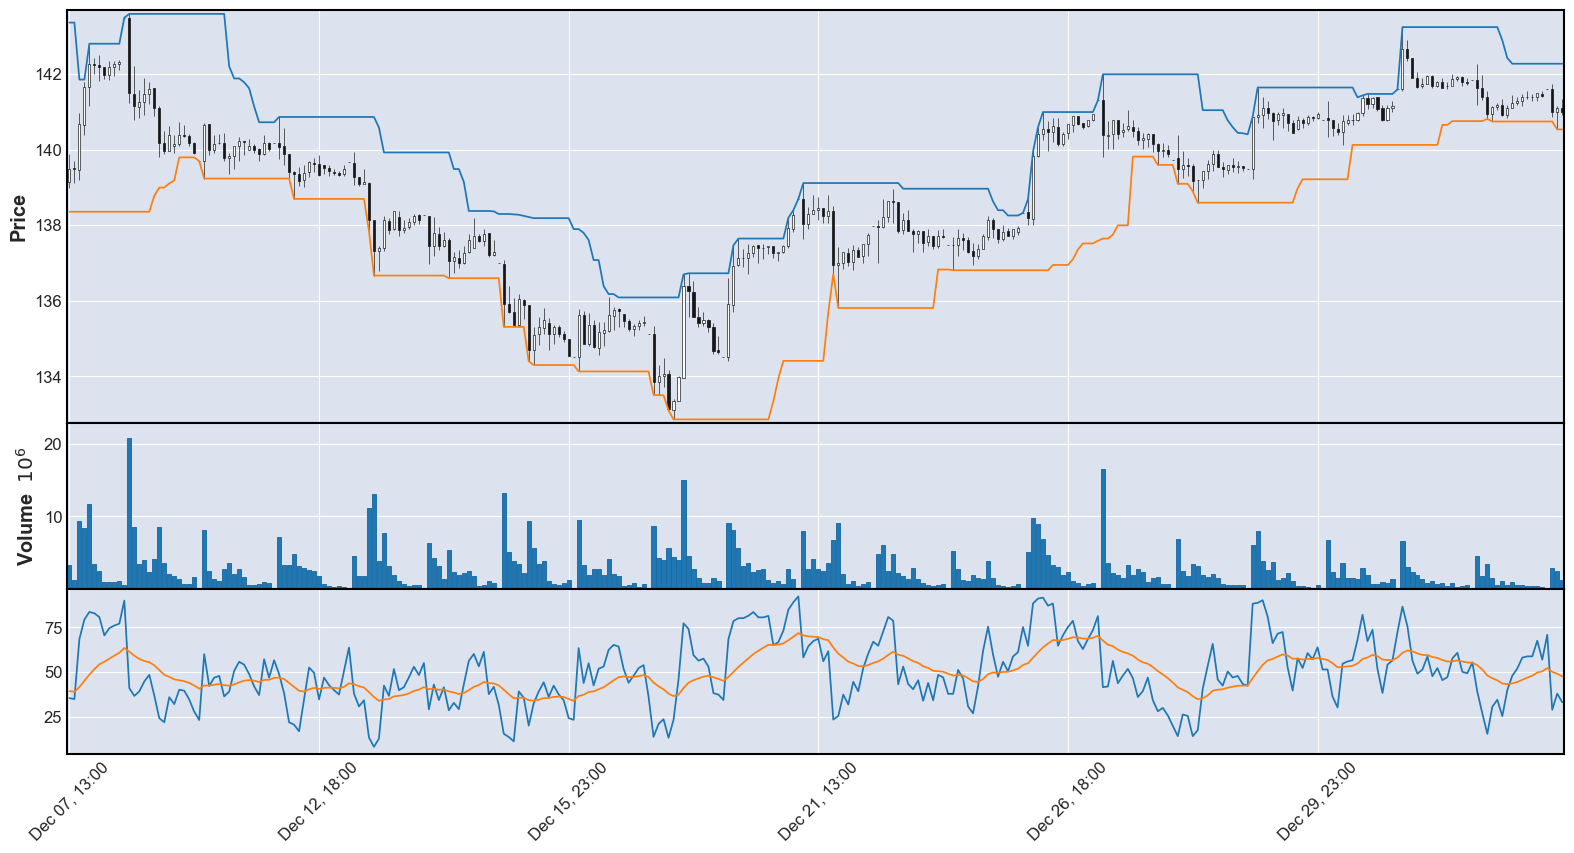

In [6]:
df_sample_for_plot = df.iloc[1800:2100]
df_sample_for_plot.index = df_sample_for_plot['date'].astype('datetime64[ns]')
df_sample_for_plot = df_sample_for_plot.drop(['date'], axis=1)

apdict = [mpf.make_addplot(df_sample_for_plot[['feature_upper_chanel', 'feature_lower_chanel']]), mpf.make_addplot(df_sample_for_plot[['feature_rsi', 'feature_rsi_ema']], panel=2)]
mpf.plot(df_sample_for_plot, type='candle', addplot=apdict, figratio=(14, 7), show_nontrading=False, volume=True, tight_layout=True,figscale=1.5)

plt.show()
plt.close()
# df_sample_for_plot

In [7]:
display(df.head())
print(df.shape)
print()
print(df.info())

,date,open,high,low,close,volume,feature_upper_chanel,feature_lower_chanel,feature_rsi,feature_rsi_ema,tic
0,2022-05-05 18:00:00,124.30,124.80,124.25,124.80,2989720,131.50,122.50,65.137694,42.669720,SBER
1,2022-05-06 09:00:00,124.74,124.74,124.74,124.74,43600,131.50,122.50,62.626662,44.800752,SBER
2,2022-05-06 10:00:00,124.74,124.99,121.52,122.46,9430400,127.50,121.52,22.120918,42.416804,SBER
3,2022-05-06 11:00:00,122.42,123.27,121.90,122.53,3760250,126.23,121.52,24.007184,40.508814,SBER
4,2022-05-06 12:00:00,122.47,123.00,122.00,122.27,2522840,126.21,121.52,21.580421,38.571720,SBER


(10695, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  10695 non-null  object 
 1   open                  10695 non-null  float64
 2   high                  10695 non-null  float64
 3   low                   10695 non-null  float64
 4   close                 10695 non-null  float64
 5   volume                10695 non-null  int64  
 6   feature_upper_chanel  10695 non-null  float64
 7   feature_lower_chanel  10695 non-null  float64
 8   feature_rsi           10695 non-null  float64
 9   feature_rsi_ema       10695 non-null  float64
 10  tic                   10695 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 919.2+ KB
None


In [8]:
class StockTradingEnv(gym.Env):    
    # metadata = {"render.modes": ["human"]}

    def __init__(
            self,
            df,
            stock_dim,              # Размерность (количество) акций, доступных для торговли
            hmax,                   # Максимальное количество акций, которые можно купить/продать за один шаг
            initial_amount,         # Начальный баланс (сумма, с которой стартует агент)
            buy_cost_pct,           # Процент комиссии при покупке
            sell_cost_pct,          # Процент комиссии при продаже
            reward_scaling,         # Коэффициент масштабирования вознаграждения            
            state_space,            # Размерность пространства состояний
            action_space,           # Размерность пространства действий (число акций, над которыми действуем)
            tech_indicator_list,    # Список технических индикаторов для анализа акций
            turbulence_threshold=None,          # Порог турбулентности рынка для изменения логики сделок (необязательно)
            risk_indicator_col="turbulence",    # Название колонки с показателем риска/турбулентности
            make_plots=True,       # Флаг: строить графики по результатам торговли или нет
            print_verbosity=10,     # Частота вывода информации в консоль
            day=0,                  # Текущий день (индекс в данных)
            initial=True,           # Флаг, определяющий, используется ли начальное состояние
            previous_state=[],      # Предыдущее состояние (для передачи между эпизодами, если необходимо)
            model_name="",          # Имя модели (используется при сохранении результатов)
            mode="",                # Режим работы (например, 'train' или 'test')
            iteration="",           # Итерация обучения или тестирования
            rsi_on=False,           # Флаг, указывающий, используется ли RSI в торговле (необязательно)
            bonus_buy_reward=100,   # Бонусная комиссия при покупке (необязательно)
            bonus_sell_reward=100,  # Бонусная комиссия при продаже (необязательно)
            reward_window=14,       # Размер окна для расчета вознаграждения (необязательно)
            actions_dead_zone_threshold=0.75,
            one_paper_mode=False,
            enable_trade_penalty = False,   # Добавлена возможность добавить штрафы за частую торговлю
            trade_penalty_window = 100     # Окно для расчета штрафов за частую торговлю
            ):        
        
        self.day = day                                      # Инициализация номера текущего дня
        self.df = df                                        # Сохраняем переданный DataFrame с данными        
        self.stock_dim = stock_dim                          # Размерность (количество) акций        
        self.hmax = hmax                                    # Максимальное количество акций для сделки       
        self.initial_amount = initial_amount                # Начальный баланс агента        
        self.buy_cost_pct = buy_cost_pct                    # Комиссия при покупке (в процентах)        
        self.sell_cost_pct = sell_cost_pct                  # Комиссия при продаже (в процентах)        
        self.reward_scaling = reward_scaling                # Коэффициент масштабирования вознаграждения        
        self.state_space = state_space                      # Размерность пространства состояний        
        self.action_space = action_space                    # Размерность пространства действий (количество активов)        
        self.tech_indicator_list = tech_indicator_list      # Список технических индикаторов           
        self.data = self.df.loc[self.day, :]                # Инициализируем данные для текущего дня (выбираем строку по индексу day)        
        self.terminal = False                               # Флаг терминального состояния (конец данных)        
        self.make_plots = make_plots                        # Флаг для построения графиков, если необходимо        
        self.print_verbosity = print_verbosity              # Частота вывода информации        
        self.turbulence_threshold = turbulence_threshold    # Порог турбулентности для изменения поведения торговли (если задан)        
        self.risk_indicator_col = risk_indicator_col        # Название колонки с показателем риска        
        self.initial = initial                              # Флаг, используемый для определения инициализации состояния        
        self.previous_state = previous_state                # Сохранение предыдущего состояния (если используется)        
        self.model_name = model_name                        # Имя модели для сохранения результатов        
        self.mode = mode                                    # Режим работы (например, 'train' или 'test')        
        self.iteration = iteration                          # Итерация обучения/тестирования        
        self.state = self._initiate_state()                 # Инициализируем состояние среды с помощью вспомогательного метода
        self.reward = 0                                     # Инициализация переменных для расчета вознаграждения
        self.turbulence = 0                                 # , турбулентности
        self.cost = 0                                       # , стоимости сделок
        self.trades = 0                                     # , количества сделок.
        self.episode = 0                                    # Счетчик эпизодов        
        self.asset_memory = [self.initial_amount]           # Список для хранения истории изменения баланса (активов)        
        self.rewards_memory = []                            # Список для хранения истории вознаграждений        
        self.actions_memory = []                            # Список для хранения истории действий
        self.reward_buffer = []                             # буфер для хранения недавних мгновенных вознаграждений        
        self.date_memory = [self._get_date()]               # Список для хранения дат (начинается с даты первого шага)        
        self._seed()                                        # Инициализация генератора случайных чисел
        self.reward_window = reward_window                  # количество шагов для скользящей средней вознаграждения
        self.reward_buffer = []                             # буфер для хранения недавних мгновенных вознаграждений
        self.actions_dead_zone_threshold = actions_dead_zone_threshold                              # порог активности, ниже которого действия будут игнорироваться.
        self.one_paper_mode = one_paper_mode
        self.bonus_buy_reward = bonus_buy_reward
        self.bonus_sell_reward = bonus_sell_reward
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))                  # Определяем пространство действий как Box (все действия от -1 до 1)        
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.state_space,))    # Определяем пространство наблюдений (состояний) как Box с неограниченными значениями        
        self.enable_trade_penalty = enable_trade_penalty    # Флаг включения штрафа за частые операции
        self.trade_penalty_window = trade_penalty_window    # Количество шагов для расчёта штрафа
        self.trades_history = []                            # Буфер для количества сделок за каждый шаг
        self.last_trades_count = 0                          # Запоминаем, сколько сделок было до текущего шага
        self.rsi_on = rsi_on
        self.cumulative_reward_list = []                   # список для хранения накопленных вознаграждений за каждый эпизод
        self.random_n = random.randint(1000000, 9999999)   # случайное число для уникальности

    def render(self, mode="human", close=False):        
        return self.state
    

    def _seed(self, seed=None):       
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def get_sb_env(self):        
        env = DummyVecEnv([lambda: self])
        obs = env.reset()
        return env, obs
    

    def _get_date(self):   
        return self.data['date']
    

    def save_asset_memory(self):  # Сохраняем историю баланса (активов) в DataFrame 
        return pd.DataFrame({"date": self.date_memory, "account_value": self.asset_memory})
    

    def save_action_memory(self): # Сохраняем историю действий в DataFrame
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _initiate_state(self):
        if self.initial:
            state = (
                [self.initial_amount]  # Начальный капитал
                + [self.data['close']]    # Текущая цена актива 
                + [0]*self.stock_dim   # Список из нулей, длина которого равна количеству акций (или размерности актива) - На старте, если начальное состояние, агент не владеет никакими акциями, поэтому заполняется нулями.
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])  # Значения всех технических индикаторов.
                )           
        else:
            state = (
                [self.previous_state[0]]    # Баланс, который агент имел на прошлом шаге
                + [self.data['close']]         # Текущая цена актива 
                + self.previous_state[ (self.stock_dim + 1) : (self.stock_dim * 1 + 1) ]  # Срез, который должен содержать данные о количестве акций агента - текущая позиция.
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])       # Значения всех технических индикаторов.
                )
            
        return state
    
    def reset(self, seed=None, **kwargs):
        if seed:
            self._seed(seed)

        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]               # История активов начинается с начального капитала
        else:
            previous_total_asset = (
                self.previous_state[0]                              # Баланс средств (деньги) агента на момент предыдущего шага
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])  # Текущие цены активов (например, закрытия) для каждого из активов
                    * np.array(self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])  # Данные о количестве акций, которыми владеет агент для каждого актива
                    ) # * Перемножаются - вычисляется рыночная стоимость активов (цена × количество).
                )     # sum суммирует стоимость активов с балансом портфеля
            self.asset_memory = [previous_total_asset] # Cохраняет начальное значение баланса данного эпизода (наличные средства + стоимость активов).

        # Сбрасываем счетчик дня, данные, турбулентность, затраты и сделки
        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # Сбрасываем историю вознаграждений, действий и дат
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        # Увеличиваем счетчик эпизодов
        self.episode += 1

        return self.state, {}    

    
    def _update_state(self):
        state = (
            [self.state[0]]                        # Баланс агента
            + [self.data['close']]                 # Оборачиваем цену закрытия в список
            + list(self.state[(self.stock_dim + 1):(self.stock_dim * 2 + 1)])  # Позиции по активам
            + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])  # Технические индикаторы
        )
        return state
    

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1  # Проверка на достижение конца данных

        if self.terminal:  # Если достигнут конец данных

            current_price = np.array( self.state[1 : (self.stock_dim + 1)] )  # Текущие цены актива
            current_pos = np.array( self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)] )  # Текущие позиции актива
            end_total_asset = self.state[0] + sum(current_price * current_pos)            
            tot_reward = (self.state[0] + sum(current_price * current_pos) - self.initial_amount) # Чистая прибыль (или убыток) к начальному капиталу

            df_total_value = pd.DataFrame(self.asset_memory)  # DataFrame с историей изменения баланса
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory # Добавляем даты в DataFrame
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1) # Вычисляем ежедневный доход
            if df_total_value["daily_return"].std() != 0:
                sharpe = ((252 ** 0.5) * df_total_value["daily_return"].mean() / df_total_value["daily_return"].std()) # Считаем Шарп-коэффициент
            
            if self.rewards_memory:
                df_rewards = pd.DataFrame(self.rewards_memory, columns=["account_rewards"])
                self.write_cumulative_reward(f'./logs/rewards/rewards_{END_DATE}_{self.random_n}.csv', sum(self.rewards_memory))         # !!!!!!!!!!!!!!
            else:
                df_rewards = pd.DataFrame(columns=["account_rewards"])
            df_rewards["date"] = self.date_memory[:-1] # Добавляем даты в DataFrame

            # Вывод информации по эпизоду с заданной частотой (print_verbosity)
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")
                print("---------------------------------")

            # Если заданы имя модели и режим, сохраняем историю действий и значений
            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(f"results/actions_{self.mode}_{self.model_name}_{self.iteration}.csv")                
                df_total_value.to_csv(f"results/account_value_{self.mode}_{self.model_name}_{self.iteration}.csv")
                df_rewards.to_csv(f"results/account_rewards_{self.mode}_{self.model_name}_{self.iteration}.csv")
                plt.plot(self.asset_memory, "r")
                # plt.savefig(f"results/account_value_{self.mode}_{self.model_name}_{self.iteration}.png", index=False)
                plt.savefig(f"results/account_value_{self.mode}_{self.model_name}_{self.iteration}.png")

                plt.close()

            return self.state, self.reward, self.terminal, False, {}
        

        else: # Если еще не достигнут конец данных
            actions = np.where(np.abs(actions) < self.actions_dead_zone_threshold, 0, actions) # !!!
            actions = actions * self.hmax       # Приводим действия к целочисленному типу (так как нельзя купить/продать дробное количество акций)
            actions = actions.astype(int)

            if self.turbulence_threshold:       # Если порог турбулентности задан и турбулентность превышает порог, задаем принудительную продажу
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)

            current_price = np.array( self.state[1 : (self.stock_dim + 1)] )                       # Текущие цены актива
            current_pos = np.array( self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)] )  # Текущие позиции актива
            begin_total_asset = self.state[0] + sum(current_price * current_pos)                   # Суммируем все значения для получения начального капитала агента

            argsort_actions = np.argsort(actions)                                   # Сортируем индексы действий по их величине
            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]       # Определяем индексы для продажи (отрицательные действия)
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]  # Определяем индексы для покупки (положительные действия)
            
            for index in sell_index:             # Выполняем операции продажи для каждого актива
                actions[index] = self._sell_stock(index, actions[index]) * (-1)

            for index in buy_index:              # Выполняем операции покупки для каждого актива
                actions[index] = self._buy_stock(index, actions[index])            

            self.actions_memory.append(actions)  # Сохраняем историю действий            

            self.day += 1                        # Переходим к следующему дню
            self.data = self.df.loc[self.day, :] # Получаем данные для нового дня
            if self.turbulence_threshold:
                self.turbulence = self.data[self.risk_indicator_col].values[0]

            self.state = self._update_state()    # Обновляем состояние с учетом новых данных

            end_total_asset = (                  # Вычисляем баланс после совершения действий
                self.state[0]
                + sum(
                    np.array( self.state[1 : (self.stock_dim + 1)] )
                    * np.array( self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)] )
                    )
                )
            self.asset_memory.append(end_total_asset)         # Сохраняем баланс после совершения действий
            self.date_memory.append(self._get_date())         # Сохраняем дату текущего состояния

            ### ВЫЧИСЛЕНИЕ ВОЗНАГРАЖДЕНИЯ ###
            self.reward = end_total_asset - begin_total_asset # Вычисляем вознаграждение за совершенные действия
            self.reward = self.reward * self.reward_scaling   # Масштабируем вознаграждение
            
            ## !!!!!!!!!!!!!!!!!!! ### ВЫЧИСЛЕНИЕ ДИНАМИЧЕСКОГО ШТРАФА ЗА ЧАСТУЮ ТОРГОВЛЮ
            trades_this_step = self.trades - self.last_trades_count 
            self.last_trades_count = self.trades
            self.trades_history.append(trades_this_step)
            if len(self.trades_history) > self.trade_penalty_window:
                self.trades_history.pop(0)
            
            if self.enable_trade_penalty:
                trade_count = sum(self.trades_history)
                dynamic_penalty = trade_count / self.trade_penalty_window  # Например, 1 сделка -> ~0.01, 100 сделок -> 1.0
                self.reward -= dynamic_penalty
            ## !!!!!!!!!!!!!!!!!!! ### !!!!!!!!!!!!!!!!!!!!!!!!!!! ###

            self.rewards_memory.append(self.reward)

            return self.state, self.reward, self.terminal, False, {}
        
    def write_cumulative_reward(self, filename, cumulative_reward):
        # Если файл существует, дописываем новую строку
        if os.path.exists(filename):
            with open(filename, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([cumulative_reward])
        else:
            # Если файл не существует, создаём его с заголовком и первой строкой
            with open(filename, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["cumulative reward"])
                writer.writerow([cumulative_reward])

    

    def _buy_stock(self, index, action):

        def _do_buy():
            # Проверяем, что цена акции положительна
            if self.state[index + 1] > 0:
                if self.one_paper_mode:
                    # Если режим торговли одной акцией включен
                    if self.state[index + self.stock_dim + 1] == 0 and action > 0:
                        # Если агент не держит акцию и сигнал покупки положительный
                        if self.state[0] >= self.state[index + 1] * (1 + self.buy_cost_pct):
                            buy_num_shares = 1
                            buy_amount = self.state[index + 1] * (1 + self.buy_cost_pct)
                        else:
                            buy_num_shares = 0
                            buy_amount = 0
                    else:
                        buy_num_shares = 0
                        buy_amount = 0
                else:
                    # Обычный режим торговли – можно купить несколько акций
                    available_amount = self.state[0] // self.state[index + 1]
                    buy_num_shares = min(available_amount, action)
                    buy_amount = self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
            else:
                buy_num_shares = 0
                buy_amount = 0

            # Если покупка совершена, обновляем баланс, позицию, затраты и счётчик сделок
            if buy_num_shares > 0:
                self.state[0] -= buy_amount
                self.state[index + self.stock_dim + 1] += buy_num_shares
                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1

            return buy_num_shares

        # Если турбулентность не превышает порог (или порог не задан) – совершаем покупку
        if self.turbulence_threshold is None or self.turbulence < self.turbulence_threshold:
            buy_num_shares = _do_buy()
        else:
            buy_num_shares = 0

        return buy_num_shares    

    def _sell_stock(self, index, action):

        def _do_sell_normal():        
            if self.state[index + 1] > 0:                                                              # Проверка: если цена акций по данному индексу больше 0 (т.е. данные присутствуют)
                if self.state[index + self.stock_dim + 1] > 0:                                         # Проверка: если количество акций на счету больше 0                    
                    sell_num_shares = min(abs(action), self.state[index + self.stock_dim + 1])         # Вычисляем количество акций для продажи: минимальное между абсолютным значением action и доступными акциями
                    sell_amount = (self.state[index + 1] * sell_num_shares * (1 - self.sell_cost_pct)) # Вычисляем сумму, полученную от продажи с учетом комиссии                    
                    self.state[0] += sell_amount                                                       # Обновляем баланс, добавляя сумму продажи                    
                    self.state[index + self.stock_dim + 1] -= sell_num_shares                          # Вычитаем проданное количество акций из портфеля                    
                    self.cost += (self.state[index + 1] * sell_num_shares * self.sell_cost_pct)        # Увеличиваем затраты на комиссию                    
                    self.trades += 1                                                                   # Увеличиваем счетчик сделок
                else:                    
                    sell_num_shares = 0                                                                # Если акций недостаточно, продажа не производится
            else:
                sell_num_shares = 0
            
            return sell_num_shares  # Количество проданных акций        
        
        if self.turbulence_threshold:                                               # Если порог турбулентности задан
            if self.turbulence >= self.turbulence_threshold:                        # И если он больше заданного порога - меняем стратегию продажи
                if self.state[index + 1] > 0:                                       # Если цена больше 0, проводим операцию продажи всех доступных акций
                    if self.state[index + self.stock_dim + 1] > 0:                        
                        sell_num_shares = self.state[index + self.stock_dim + 1]    # Продаем все акции данного актива
                        sell_amount = (self.state[index + 1] * sell_num_shares * (1 - self.sell_cost_pct))
                        self.state[0] += sell_amount                        
                        self.state[index + self.stock_dim + 1] = 0                  # Обнуляем количество акций после продажи
                        self.cost += (self.state[index + 1] * sell_num_shares * self.sell_cost_pct)
                        self.trades += 1                                            # Увеличиваем счетчик сделок
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:                
                sell_num_shares = _do_sell_normal()                                 # Если турбулентность ниже порога, выполняем стандартную продажу
        else:            
            sell_num_shares = _do_sell_normal()                                     # Если порог турбулентности не задан, выполняем стандартную продажу

        return sell_num_shares        # Количество проданных акций (с отрицательным знаком для учета направления действия)    

In [9]:
ratio_list = ['feature_upper_chanel', 'feature_lower_chanel', 'feature_rsi', 'feature_rsi_ema']
stock_dimension = len(df['tic'].unique())
state_space = 1 + 2*stock_dimension + len(ratio_list) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 7


In [10]:
# Параметры среды (модели рынка)
env_kwargs = {
        "hmax": 10, 
        "initial_amount": 100000, 
        "buy_cost_pct": 0.003,
        "sell_cost_pct": 0.003,
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": ratio_list, 
        "action_space": stock_dimension, 
        # "reward_scaling": 1e-4,
        "reward_scaling": 1e3,
        "model_name": "ppo",
        "mode": "train",
        # "bonus_buy_reward": 10000,
        # "bonus_sell_reward": 1000,
        # "one_paper_mode": True,
        "actions_dead_zone_threshold": 0.2,
        "enable_trade_penalty": False,
        "trade_penalty_window": 10,
    }

ppo_params = {
        "n_steps": 2024,
        "ent_coef": 0.01,
        "learning_rate": 0.00025,
        "batch_size": 128,
        "device": "cpu",
        "gamma": 0.999
    }

env, _ = StockTradingEnv(df = df, **env_kwargs).get_sb_env()
agent = DRLAgent(env = env)
model_ppo = agent.get_model("ppo", model_kwargs = ppo_params)

# set up logger
tmp_path = 'results' + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])

# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2024, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128, 'device': 'cpu', 'gamma': 0.999}
Using cpu device


c:\Desk\Data\Otus\alqotrading_beta\venv\Lib\site-packages\stable_baselines3\ppo\ppo.py:155: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2024`, after every 15 untruncated mini-batches, there will be a truncated mini-batch of size 104
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2024 and n_envs=1)
  warnings.warn(


Logging to results/ppo


In [11]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeRewardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []        # временный буфер для наград текущего эпизода
        self.cumulative_rewards = []     # итоговый список кумулятивных наград по эпизодам

    def _on_step(self) -> bool:
        # Получаем награду текущего шага. Если используется векторизованная среда, возьмем первое значение.
        reward = self.locals.get("rewards", None)
        if reward is not None:
            self.episode_rewards.append(reward[0])
        return True

    def _on_rollout_end(self) -> None:
        # По окончании rollout'а считаем суммарную награду за эпизод
        cumulative_reward = sum(self.episode_rewards)
        self.cumulative_rewards.append(cumulative_reward)
        self.logger.record("episode/cumulative_reward", cumulative_reward)
        print(f"Episode cumulative reward: {cumulative_reward}")
        # Очищаем буфер для следующего эпизода
        self.episode_rewards = []


In [12]:
# trained_ppo = model_ppo.load('./trained_models/trained_ppo.model')
trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=len(df) * 10)

trained_ppo.save('./trained_models/trained_ppo.model')

env.close()

--------------------------------
| time/              |         |
|    fps             | 2094    |
|    iterations      | 1       |
|    time_elapsed    | 0       |
|    total_timesteps | 2024    |
| train/             |         |
|    reward          | -6297.6 |
--------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1678          |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 4048          |
| train/                  |               |
|    approx_kl            | 1.8004774e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0             |
|    learning_rate        | 0.00025       |
|    loss                 | 2.37e+10      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000115     |

<Axes: >

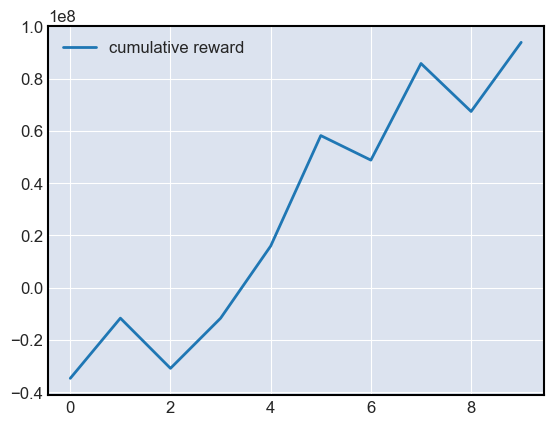

In [ ]:
pd.read_csv('./logs/rewards/rewards_2025-03-28_5659362.csv').plot()

In [19]:
df_rewards = pd.read_csv('./results/account_rewards_train_ppo_.csv', index_col=0)
df_values = pd.read_csv('./results/account_value_train_ppo_.csv', index_col=0)
df_actions = pd.read_csv('./results/actions_train_ppo_.csv', index_col=0)

df_actions['date'] = pd.to_datetime(df_actions['date'])
df_values['date'] = pd.to_datetime(df_values['date'])
df_rewards['date'] = pd.to_datetime(df_rewards['date'])

try:
    df_output = df.merge(df_actions, on='date', how='left').merge(df_values, on='date', how='left').merge(df_rewards, on='date', how='left')
except ValueError:
    df['date'] = pd.to_datetime(df['date'])
    df_output = df.merge(df_actions, on='date', how='left').merge(df_values, on='date', how='left').merge(df_rewards, on='date', how='left')

df_output['actions'] = df_output['actions'].dropna().apply(lambda x: int(x.strip('[]')))
df_output['actions'] = df_output['actions'].fillna(0).astype(int)
df_output['cumulative_actions'] = df_output['actions'].cumsum()
df_output['account_rewards'] = df_output['account_rewards'].fillna(0).astype(int)
df_output['cumulative_rewards'] = df_output['account_rewards'].cumsum()
df_output['market_yeld'] = df_output['close'] * (df_output.loc[0, 'account_value'] / df_output.loc[0, 'close'])

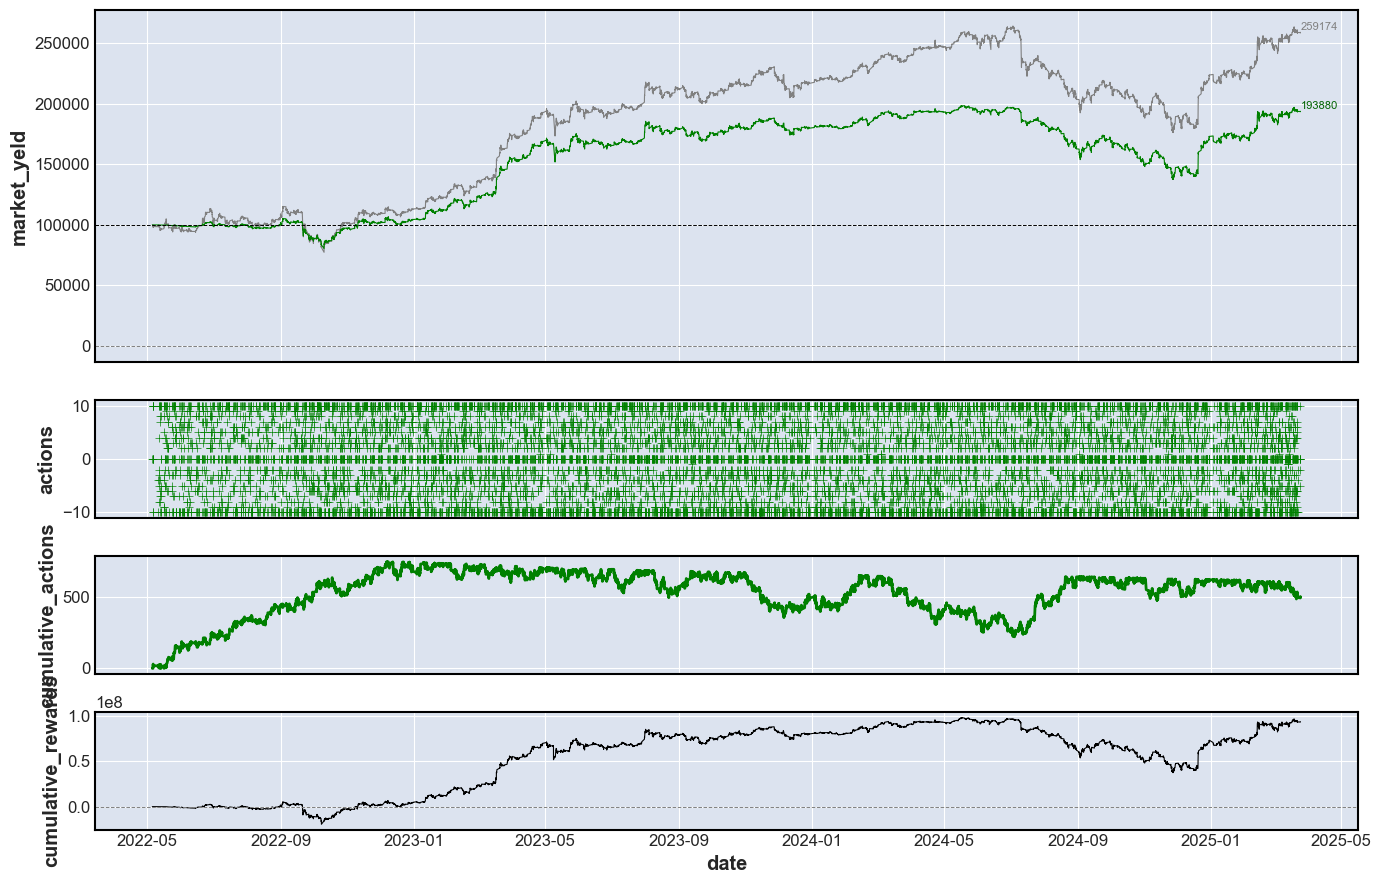

In [20]:
fig, ax = plt.subplots(4,1,figsize=(14, 9), sharex=True, height_ratios=[3,1,1,1])

sns.lineplot(x='date', y='market_yeld', data=df_output, ax=ax[0], color='grey', lw=0.8)
# sns.lineplot(x='date', y=((df_output['cumulative_actions'] * df_output['close']) + df_output['close'].iloc[0]).pct_change().fillna(0).cumsum(), data=df_output, ax=ax[0], color='red', lw=0.8)
sns.lineplot(x='date', y='account_value', data=df_output, ax=ax[0], color='green', lw=0.8)
sns.scatterplot(x='date', y='actions', data=df_output, ax=ax[1], color='green', marker='+')
sns.lineplot(x='date', y='cumulative_actions', data=df_output, ax=ax[2], color='green')
# sns.scatterplot(x='date', y='account_rewards', data=df_output, ax=ax[3], color='black', marker='+')
sns.lineplot(x='date', y='cumulative_rewards', data=df_output, ax=ax[3], color='black', lw=0.8)

plt.axhline(0, color='grey', linestyle='--', lw=0.7)
plt.sca(ax[0])
plt.axhline(env_kwargs['initial_amount'], color='black', linestyle='--', lw=0.7)

final_value = int(df_output.iloc[-1]['account_value'])
final_market_value = int(df_output.iloc[-1]['market_yeld'])
plt.text(df_output['date'].iloc[-1], final_value + env_kwargs['initial_amount'] / 50, final_value, fontsize=8, color='darkgreen')
plt.text(df_output['date'].iloc[-1], final_market_value + env_kwargs['initial_amount'] / 50, final_market_value, fontsize=8, color='grey')
# plt.sca(ax[1])
plt.axhline(0, color='grey', linestyle='--', lw=0.7)

# plt.xlim(df_output['date'].iloc[820], df_output['date'].iloc[860])
plt.tight_layout()
plt.show()
plt.close()

In [16]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# fig = make_subplots(rows=4, cols=1, shared_xaxes=True, row_heights=[3, 1, 1, 1], vertical_spacing=0.03)

# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['market_yeld'], mode='lines', line=dict(color='grey', width=0.8), name='Market Yeld'), row=1, col=1)
# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['account_value'], mode='lines', line=dict(color='green', width=0.8), name='Account Value'), row=1, col=1)
# fig.add_shape(type="line", xref="x1", yref="y1", x0=df_output['date'].min(), x1=df_output['date'].max(), y0=env_kwargs['initial_amount'], y1=env_kwargs['initial_amount'], line=dict(color="black", width=0.7, dash="dash"))

# final_value = int(df_output.iloc[-1]['account_value'])
# final_market_value = int(df_output.iloc[-1]['market_yeld'])
# last_date = df_output['date'].iloc[-1]
# y_offset = env_kwargs['initial_amount'] / 50

# fig.add_annotation(x=last_date, y=final_value + y_offset, xref="x1", yref="y1", text=str(final_value), showarrow=False, font=dict(color='darkgreen', size=8))
# fig.add_annotation(x=last_date, y=final_market_value + y_offset, xref="x1", yref="y1", text=str(final_market_value), showarrow=False, font=dict(color='grey', size=8))

# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['actions'], mode='markers', marker=dict(color='green', symbol='cross'), name='Actions'), row=2, col=1)
# fig.add_shape(type="line", xref="x2", yref="y2", x0=df_output['date'].min(), x1=df_output['date'].max(), y0=0, y1=0, line=dict(color="grey", width=0.7, dash="dash"))
# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['cumulative_actions'], mode='lines', line=dict(color='green'), name='Cumulative Actions'), row=3, col=1)
# fig.add_trace(go.Scatter(x=df_output['date'], y=df_output['cumulative_rewards'], mode='lines', line=dict(color='black', width=0.8), name='Cumulative Rewards'), row=4, col=1)

# fig.update_layout(height=900, width=1400, showlegend=False, margin=dict(l=50, r=50, t=50, b=50))

# fig.update_xaxes(title_text="Date")

# fig.write_html("plot.html")
# # fig.show()

In [21]:
df_output.head() #['daily_return'].describe()

,date,open,high,low,close,volume,feature_upper_chanel,feature_lower_chanel,feature_rsi,feature_rsi_ema,tic,actions,account_value,daily_return,account_rewards,cumulative_actions,cumulative_rewards,market_yeld
0,2022-05-05 18:00:00,124.30,124.80,124.25,124.80,2989720,131.50,122.50,65.137694,42.669720,SBER,0,100000.0000,NaN,0,0,0,100000.000000
1,2022-05-06 09:00:00,124.74,124.74,124.74,124.74,43600,131.50,122.50,62.626662,44.800752,SBER,0,100000.0000,0.000000,0,0,0,99951.923077
2,2022-05-06 10:00:00,124.74,124.99,121.52,122.46,9430400,127.50,121.52,22.120918,42.416804,SBER,10,100000.0000,0.000000,-2973,10,-2973,98125.000000
3,2022-05-06 11:00:00,122.42,123.27,121.90,122.53,3760250,126.23,121.52,24.007184,40.508814,SBER,10,99997.0262,-0.000030,-8875,20,-11848,98181.089744
4,2022-05-06 12:00:00,122.47,123.00,122.00,122.27,2522840,126.21,121.52,21.580421,38.571720,SBER,10,99988.1503,-0.000089,831,30,-11017,97972.756410
